In [1]:
import os
import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datetime import datetime
from multiprocessing import Manager
from PIL import Image

In [2]:
class CFG:
    batch_size = 16
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    epochs = 12
    lr = 1e-4
    model_name = 'resnet'
    num_classes = 6
    nworkers = 1
    nfolds = 4
    seed = 524
    test_split = 516
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

# Split Data

In [3]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

train, test = train_test_split(train, test_size=CFG.test_split, random_state=CFG.seed)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

if CFG.debug:
    df = train.sample(n=50, random_state=CFG.seed).copy()
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,89ce8e0a494db9c7ddc68dbf58729c68,radboud,1,3+3,0
1,ef9c72d529806d9ba341476d4c159838,radboud,5,5+4,2
2,139e1e89bca7897799f80da93adcd3c7,karolinska,0,0+0,1
3,0abc61a1bc7abe47b9e44a9f69979eb0,karolinska,2,3+4,3
4,fe7812f20a38495743cf7bf7f811c108,karolinska,1,3+3,1


In [4]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        # For weighted sampler
        class_counts = [len(labels[labels==g]) for g in range(CFG.num_classes)]
        self.num_samples = sum(class_counts)
        class_weights = [self.num_samples/class_counts[i] for i in range(len(class_counts))]
        self.weights = [class_weights[labels[i]] for i in range(self.num_samples)]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #worker = torch.utils.data.get_worker_info()
        #worker_id = worker.id if worker is not None else -1
        #start = time.time()
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        img_fns = [fn for fn in glob.glob(f"{CFG.TRAIN}/{self.df['image_id'][idx]}_*.png")]
        imgs = [cv2.imread(fn) for fn in img_fns]
        # (D,W,H)
        img = cv2.hconcat([cv2.vconcat([imgs[0], imgs[1], imgs[2], imgs[3]]),
                           cv2.vconcat([imgs[4], imgs[5], imgs[6], imgs[7]]),
                           cv2.vconcat([imgs[8], imgs[9], imgs[10], imgs[11]]),
                           cv2.vconcat([imgs[12], imgs[13], imgs[14], imgs[15]])])
        img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
            
        label = self.labels[idx]
        #end = time.time()
        return img, label

## Transforms

In [5]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, fill=255),
            T.ToTensor(),
            T.Normalize(
                mean=[0.8776, 0.8186, 0.9090],
                std=[0.1659, 0.2507, 0.1357],
            ),
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.8776, 0.8186, 0.9090],
                std=[0.1659, 0.2507, 0.1357],
            ),
        ])

In [6]:
# Use fold idx as validation set
def data_loader(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_sampler = WeightedRandomSampler(weights=train_dataset.weights, num_samples=train_dataset.num_samples)
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=train_sampler, num_workers=CFG.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.nworkers)
    return train_loader, val_loader

In [7]:
def train_model(model, fold, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                # Skip evaluation for test dataset except for the last epoch
                if (len(dataloaders[phase].dataset) != CFG.test_split) or (num_epochs == epoch+1):
                    model.eval()    # Set model to evaluate phase
                else:
                    continue
            
            avg_loss = 0.0
            running_corrects = 0
            
            print(' ', end='', flush=True)  # To workaround tqdm issue in multiprocess
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='[{}] {}/{}({:5s})'.format(fold, epoch+1,num_epochs,phase)):
                inputs = inputs.to(device=CFG.device, dtype=CFG.dtype)
                labels = labels.to(device=CFG.device, dtype=torch.long)
                #print(labels)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    pred = torch.argmax(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                avg_loss += loss.item()*(inputs.size(0)/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                running_corrects += torch.sum(pred == labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                    # Apply lr_scheduler
                    if scheduler is not None:
                        scheduler.step(avg_loss)
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('[{}] {} Loss: {:4f} Acc: {:4f}'.format(fold, phase, avg_loss, epoch_acc))
    
    time_elapsed = time.time() - since
    print('[{}] Training complete in {:.0f}m {:0f}s'.format(fold, time_elapsed//60, time_elapsed%60))
    print('[{}] Best val Acc: {:4f}'.format(fold, best_acc))
    print()
    
    model.load_state_dict(best_model_wts)
                      
    return model, loss_history, train_acc_history, val_acc_history

In [8]:
"""Multiprocessing
"""
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

def train_fn(fold):
    model_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=True)
    """
    optimizer = optim.SGD(model_ft.parameters(),
                          lr=CFG.lr,
                          momentum=.9,
                          nesterov=True)
    """
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    #print(f'### FOLD: {fold} ###', flush=True)
    loader_train, loader_val = data_loader(fold)
    best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, fold, {'train': loader_train, 'val': loader_val}, F.cross_entropy, optimizer, scheduler, CFG.epochs)

    return best_model, loss_history, train_acc_history, val_acc_history

def progressor(fold):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    return {f'best_mode_{fold}': best_model,
            f'loss_history_{fold}': loss_history,
            f'train_acc_history_{fold}': train_acc_history,
            f'val_acc_history_{fold}': val_acc_history}

## Resnet18
log: resnet_06_01_2020_13_11.pkl

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False):
    """
    Params:
        feature_extract
            True - fine tunning
            False - fix the model
    """
    model_ft = None
    
    if model_name == 'alexnet':
        """AlexNet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        """Resnet
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    return model_ft

In [10]:
log_dict = {'batch_size': CFG.batch_size,
            'epochs': CFG.epochs,
            'learning_rate': CFG.lr,
            'model': CFG.model_name,
            'nworkers': CFG.nworkers,
            'nfolds': CFG.nfolds,
            'random_seed': CFG.seed}

nfold = range(CFG.nfolds)
result_list = list(MyPool(CFG.nfolds).map(progressor, nfold))

# Accumulate result from each process
for result in result_list:
    log_dict.update(result)

# Log results
log_file = f'{CFG.model_name}_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)


[0] train Loss: 1.418241 Acc: 0.424133
 


[1] train Loss: 1.430029 Acc: 0.405733
 


[2] train Loss: 1.435485 Acc: 0.410533
 


[3] train Loss: 1.425638 Acc: 0.414667
 


[1] val Loss: 1.248337 Acc: 0.512000
 
[2] val Loss: 1.245579 Acc: 0.490800
 


[0] val Loss: 1.232799 Acc: 0.508800
 


[3] val Loss: 1.462078 Acc: 0.408400
 


[0] train Loss: 1.282845 Acc: 0.481867
 


[1] train Loss: 1.277802 Acc: 0.483733
 


[2] train Loss: 1.289896 Acc: 0.484267
 


[3] train Loss: 1.280848 Acc: 0.485333
 


[0] val Loss: 1.546893 Acc: 0.392800
 


[1] val Loss: 1.296753 Acc: 0.481600
 


[2] val Loss: 1.239004 Acc: 0.504400
 


[3] val Loss: 1.191321 Acc: 0.536400
 


[0] train Loss: 1.215737 Acc: 0.509067
 


[3] train Loss: 1.214030 Acc: 0.507733
 


[1] train Loss: 1.223679 Acc: 0.509733
 


[2] train Loss: 1.225289 Acc: 0.504933
 


[0] val Loss: 1.228263 Acc: 0.519200
 


[3] val Loss: 1.320089 Acc: 0.508800
 


[2] val Loss: 1.218872 Acc: 0.526800
 


[1] val Loss: 1.270450 Acc: 0.492000
 


[0] train Loss: 1.197335 Acc: 0.521867
 


[1] train Loss: 1.184704 Acc: 0.524800
 


[2] train Loss: 1.170872 Acc: 0.535467
 


[3] train Loss: 1.165032 Acc: 0.533467
 


[0] val Loss: 1.350557 Acc: 0.488000
 


Epoch     4: reducing learning rate of group 0 to 1.0000e-05.
[1] val Loss: 1.306970 Acc: 0.462800
 


[2] val Loss: 1.192547 Acc: 0.536000
 


[3] val Loss: 1.303577 Acc: 0.480400
 


[0] train Loss: 1.129353 Acc: 0.546267
 


[1] train Loss: 1.073719 Acc: 0.577467
 


[3] train Loss: 1.119499 Acc: 0.555067
 


[2] train Loss: 1.120360 Acc: 0.555067
 


[0] val Loss: 1.129413 Acc: 0.559600
 


Epoch     5: reducing learning rate of group 0 to 1.0000e-05.
[3] val Loss: 1.320610 Acc: 0.503200
 


[1] val Loss: 1.085490 Acc: 0.569200
 


[2] val Loss: 1.150692 Acc: 0.554800
 


[0] train Loss: 1.098651 Acc: 0.567333
 


[1] train Loss: 1.040617 Acc: 0.596133
 


[3] train Loss: 1.021516 Acc: 0.599200
 


[2] train Loss: 1.084209 Acc: 0.571467
 


[0] val Loss: 1.212104 Acc: 0.530000
 


[1] val Loss: 1.078267 Acc: 0.571600
 


[3] val Loss: 1.086741 Acc: 0.582000
 


[2] val Loss: 1.156390 Acc: 0.549200
 


[0] train Loss: 1.058819 Acc: 0.584000
 


[1] train Loss: 1.013772 Acc: 0.608400
 


[2] train Loss: 1.059750 Acc: 0.581067
 


[3] train Loss: 0.966618 Acc: 0.623600
 


[0] val Loss: 1.343749 Acc: 0.498400
 


[1] val Loss: 1.066870 Acc: 0.588800
 


[2] val Loss: 1.326790 Acc: 0.511600
 


[3] val Loss: 1.061899 Acc: 0.591600
 


[0] train Loss: 1.013409 Acc: 0.610000
 


[1] train Loss: 0.969464 Acc: 0.630533
 


[2] train Loss: 1.011878 Acc: 0.598267
 


[3] train Loss: 0.938800 Acc: 0.638267
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[0] val Loss: 1.293950 Acc: 0.510000
 


[1] val Loss: 1.076673 Acc: 0.588400
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[2] val Loss: 1.171535 Acc: 0.555600
 


[3] val Loss: 1.058128 Acc: 0.597200
 


[0] train Loss: 0.915568 Acc: 0.649333
 


[1] train Loss: 0.973950 Acc: 0.622000
 


[2] train Loss: 0.877323 Acc: 0.667200
 


[3] train Loss: 0.913890 Acc: 0.652133
 


[0] val Loss: 1.080313 Acc: 0.585200
 


[1] val Loss: 1.097499 Acc: 0.575200
 


[2] val Loss: 1.071298 Acc: 0.589600
 


[3] val Loss: 1.072213 Acc: 0.594000
 


[0] train Loss: 0.840296 Acc: 0.687333
 


[2] train Loss: 0.819084 Acc: 0.694667
 


[3] train Loss: 0.870724 Acc: 0.673333
 


[1] train Loss: 0.945286 Acc: 0.634133
 


[0] val Loss: 1.050435 Acc: 0.591200
 


[3] val Loss: 1.053434 Acc: 0.606000
 


[2] val Loss: 1.044258 Acc: 0.600800
 


[1] val Loss: 1.055935 Acc: 0.597200
 


[0] train Loss: 0.806113 Acc: 0.696933
 


[3] train Loss: 0.869484 Acc: 0.672400
 


[2] train Loss: 0.774755 Acc: 0.716800
 


[1] train Loss: 0.921322 Acc: 0.653867
 


[0] val Loss: 1.048555 Acc: 0.601600
 


[2] val Loss: 1.075104 Acc: 0.586000
 


[3] val Loss: 1.071824 Acc: 0.599600
 


[1] val Loss: 1.067045 Acc: 0.592400
 


[0] train Loss: 0.787452 Acc: 0.701067
 


[3] train Loss: 0.836986 Acc: 0.685067
 


[1] train Loss: 0.906319 Acc: 0.649600
 


[2] train Loss: 0.754275 Acc: 0.718667
 


[0] val Loss: 1.050803 Acc: 0.599200
[0] Training complete in 1118m 28.733871s
[0] Best val Acc: 0.601600


[3] val Loss: 1.054158 Acc: 0.606000
[3] Training complete in 1123m 12.016683s
[3] Best val Acc: 0.606000


[2] val Loss: 1.049828 Acc: 0.588800
[2] Training complete in 1123m 14.518635s
[2] Best val Acc: 0.600800


[1] val Loss: 1.060938 Acc: 0.592000
[1] Training complete in 1123m 14.939176s
[1] Best val Acc: 0.597200



In [11]:
"""
for fold in range(CFG.nfolds):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    log_dict[f'best_mode_{fold}'] = best_model
    log_dict[f'loss_history_{fold}'] = loss_history
    log_dict[f'train_acc_history_{fold}'] = train_acc_history
    log_dict[f'val_acc_history_{fold}'] = val_acc_history
"""

"\nfor fold in range(CFG.nfolds):\n    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)\n    log_dict[f'best_mode_{fold}'] = best_model\n    log_dict[f'loss_history_{fold}'] = loss_history\n    log_dict[f'train_acc_history_{fold}'] = train_acc_history\n    log_dict[f'val_acc_history_{fold}'] = val_acc_history\n"

"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(log_dict['loss_history_0'], 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(log_dict['train_acc_history_0'], '-o')
plt.plot(log_dict['val_acc_history_0'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.tight_layout(pad=3)
plt.show()

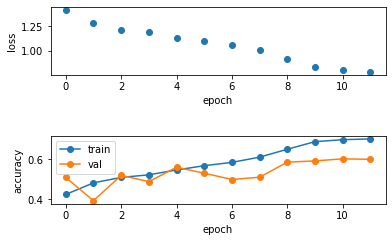

In [12]:
# read python dict back from the file
#with open('resnet_06_06_2020_19_27.pkl', 'rb') as pfile:
#    test_dict = pickle.load(pfile)
"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(log_dict['loss_history_0'], 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(log_dict['train_acc_history_0'], '-o')
plt.plot(log_dict['val_acc_history_0'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.tight_layout(pad=3)
plt.show()

In [13]:
preds, targets = [], []
for fold in range(CFG.nfolds):
    model_fd = log_dict[f'best_mode_{fold}']
    _, loader_val = data_loader(fold)
    for inputs, labels in tqdm(loader_val):
        inputs = inputs.to(device=CFG.device, dtype=CFG.dtype)
        labels = labels.to(device=CFG.device, dtype=torch.long)
                
        # Forward, track history if only in training
        with torch.no_grad():
            outputs = model_fd(inputs)
            pred = torch.argmax(outputs, 1)
        preds.append(pred)
        targets.append(labels)

Kappa: 0.7414910361034592


Text(69.0, 0.5, 'True label')

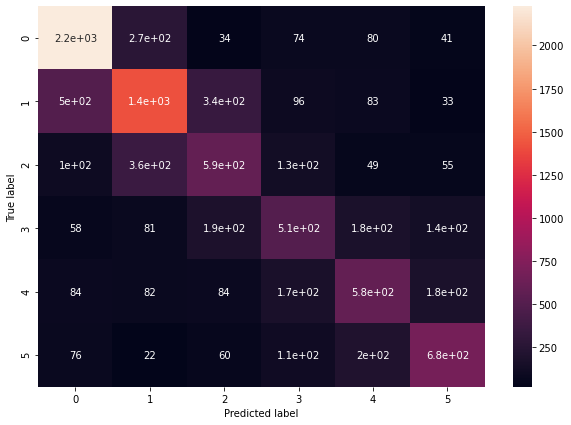

In [18]:
p = torch.cat(preds).cpu()
t = torch.cat(targets).cpu()
kappa = cohen_kappa_score(t, p, weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t,p)
#plt.matshow()
plt.figure(figsize=(10,7))
sn.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')